<a href="https://colab.research.google.com/github/maxwiedmann/DSI_project_5__ee_water_levels/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
### <i>Classifier Modeling</i>
----
Here we will import water–level depths from Google Earth Engine measured by counting isolated water pixels over time. In conjunction with the image reading we have obtained a csv file from NOAA (National Oceanic and Atmospheric Administration) detailing storm data in Butte County, CA. This data spans from 2013–04–27 to 2020–07–26.

Gaps in calendar dates between the two csv files will be filled with a `daterange()` function while missing water levels will be imputed with a seasonal mean in an effort to maintain our record counts. Alleviating missing values (i.e. images that were not recorded in GEE for certain dates) could concisderably affect our model if any gaps in months/seasons were observed.

----
----

In [3]:
## set html cleaning tag for readme

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,\
AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,\
ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
#
#import xgboost as xgb

In [8]:
# GEE Water Pixel Measurement.
water = pd.read_csv('./Charts/data/houston_water_levels_data.csv')
# NOAA storm dataset.
storm_df = pd.read_csv('./storm_data_search_results.csv')

In [9]:
water[:10]

,system:time_start,waterArea
0,"Mar 27, 2013",11.104
1,"Mar 27, 2013",20.158
2,"Apr 1, 2013",3.996
3,"Apr 1, 2013",6.113
4,"Apr 11, 2013",9.133
5,"Apr 11, 2013",10.643
6,"Apr 27, 2013",3.316
7,"Apr 27, 2013",5.470
8,"May 4, 2013",10.043
9,"May 13, 2013",5.923


In [10]:
water['system:time_start'] = pd.to_datetime(water['system:time_start'])
water.rename(columns = {'system:time_start': 'date',
             'waterArea': 'water_level'}, inplace = True)
water.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         529 non-null    datetime64[ns]
 1   water_level  529 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.4 KB


In [11]:
water.head()

,date,water_level
0,2013-03-27,11.104
1,2013-03-27,20.158
2,2013-04-01,3.996
3,2013-04-01,6.113
4,2013-04-11,9.133


---
For some reason we have multiple records for individual dates in our water pixel measurement dataset. This could be due to multiple images being taken in a single day, script bugs, etc.. Due to time constraints in lieu of conducting de–bugging on the script we will instead take the average water level recorded of any duplicative dates.

----

In [12]:
water['date'].value_counts()
#do a date groupby.mean()

2013-08-08    2
2016-01-30    2
2015-08-14    2
2020-07-10    2
2017-06-09    2
             ..
2015-04-08    1
2017-08-03    1
2016-11-29    1
2013-10-27    1
2018-09-23    1
Name: date, Length: 282, dtype: int64

In [13]:
#`df.resample()` is similar to `df.groupby()`, but with dates instead of categories.
    # this will ALSO fill in any gaps in dates and eliminate need for daterange()
water.set_index('date',inplace = True)
water.sort_index(inplace = True)
water = water.resample('D').mean()

In [14]:
water.head()

,water_level
date,
2013-03-27,15.631
2013-03-28,NaN
2013-03-29,NaN
2013-03-30,NaN
2013-03-31,NaN


In [15]:
feats = ['BEGIN_LOCATION', 'BEGIN_DATE', 'EVENT_TYPE',\
          'END_LOCATION', 'BEGIN_LAT', \
        'BEGIN_LON', 'END_LAT', 'END_LON']
storm_df = storm_df[feats]
storm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BEGIN_LOCATION  82 non-null     object 
 1   BEGIN_DATE      82 non-null     object 
 2   EVENT_TYPE      82 non-null     object 
 3   END_LOCATION    82 non-null     object 
 4   BEGIN_LAT       82 non-null     float64
 5   BEGIN_LON       82 non-null     float64
 6   END_LAT         82 non-null     float64
 7   END_LON         82 non-null     float64
dtypes: float64(4), object(4)
memory usage: 5.2+ KB


In [16]:
cols = {
    'BEGIN_LOCATION':'loc1',
    'BEGIN_DATE':'date',
    'EVENT_TYPE':'flood',
    'END_LOCATION':'loc2', 
    'BEGIN_LAT':'loc1_lat', \
    'BEGIN_LON':'loc1_lon',
    'END_LAT':'loc2_lat',
    'END_LON': 'loc2_lon'
}

storm_df.rename(columns=cols, inplace=True)
storm_df['date'] = pd.to_datetime(storm_df['date'])
storm_df['flood'] = 1
storm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   loc1      82 non-null     object        
 1   date      82 non-null     datetime64[ns]
 2   flood     82 non-null     int64         
 3   loc2      82 non-null     object        
 4   loc1_lat  82 non-null     float64       
 5   loc1_lon  82 non-null     float64       
 6   loc2_lat  82 non-null     float64       
 7   loc2_lon  82 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 5.2+ KB


In [61]:
# # Create a dataframe to fill in date gaps within data.
# df = pd.DataFrame(pd.date_range(min(water['date']), max(water['date'])), columns = ['dates'])
# df.info()

In [17]:
df = pd.merge(water, storm_df, left_on = water.index, right_on= storm_df['date'], right_index=False, how = 'left')
df.drop(axis = 1, columns = ['date'], inplace = True)
df.rename(columns = {'key_0':'date'},inplace = True)
df.set_index('date',inplace = True)
df.head()

,water_level,loc1,flood,loc2,loc1_lat,loc1_lon,loc2_lat,loc2_lon
date,,,,,,,,
2013-03-27,15.631,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Impute NaN with 30 rolling avg
df['water_level'].fillna(df["water_level"].rolling(min_periods=1, center=True, window=30).mean(), inplace = True)

<AxesSubplot:xlabel='date'>

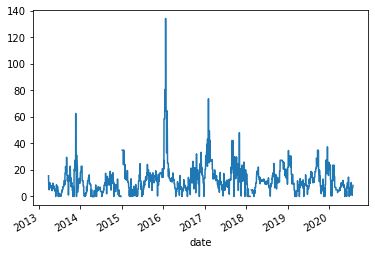

In [19]:
df['water_level'].plot()

In [20]:
#df['flood'].fillna(value = 0, inplace = True)

In [21]:
df['flood'].replace(np.nan, 0, inplace=True)

In [22]:
df.dtypes

water_level    float64
loc1            object
flood          float64
loc2            object
loc1_lat       float64
loc1_lon       float64
loc2_lat       float64
loc2_lon       float64
dtype: object

---
Create features to measure water level changes as well as percent changes. These should be strong predictors in a flood classification model.

---

In [68]:
df['water_chg'] = df['water_level'].diff()
df['water_chg'].replace(np.nan, 0, inplace=True)
df['water_pct_chg'] = df['water_level'].pct_change()
df['water_pct_chg'].replace(np.nan, 0, inplace=True)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2709 entries, 2013-03-27 to 2020-07-26
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   water_level    2689 non-null   float64
 1   loc1           82 non-null     object 
 2   flood          2709 non-null   float64
 3   loc2           82 non-null     object 
 4   loc1_lat       82 non-null     float64
 5   loc1_lon       82 non-null     float64
 6   loc2_lat       82 non-null     float64
 7   loc2_lon       82 non-null     float64
 8   water_chg      2709 non-null   float64
 9   water_pct_chg  2709 non-null   float64
dtypes: float64(8), object(2)
memory usage: 232.8+ KB


In [70]:
df[df['water_level'].isnull()==True]

,water_level,loc1,flood,loc2,loc1_lat,loc1_lon,loc2_lat,loc2_lon,water_chg,water_pct_chg
date,,,,,,,,,,
2014-04-21,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2014-04-22,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2014-12-26,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2014-12-27,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2014-12-28,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2014-12-29,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2014-12-30,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2014-12-31,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2015-01-01,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [71]:
df['flood'].value_counts(normalize = True)

0.0    0.969731
1.0    0.030269
Name: flood, dtype: float64

---
Baseline model must predict with greater than 3% accurracy if there will be a flood.

---

In [80]:
df = df[['flood', 'water_level', 'water_chg', "water_pct_chg"]]

In [81]:
df.dropna(inplace = True)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2689 entries, 2013-03-27 to 2020-07-26
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   flood          2689 non-null   float64
 1   water_level    2689 non-null   float64
 2   water_chg      2689 non-null   float64
 3   water_pct_chg  2689 non-null   float64
dtypes: float64(4)
memory usage: 105.0 KB


In [75]:
np.any(np.isnan(df))

False

In [76]:
np.any(np.isfinite(df))

True

In [77]:
df['water_chg'] = round(df['water_chg'], 1)
df['water_pct_chg'] = round(df['water_pct_chg'], 1)
df['water_level'] = round(df['water_level'], 1)

In [83]:
len(df)

2689

Text(0, 0.5, 'Flood')

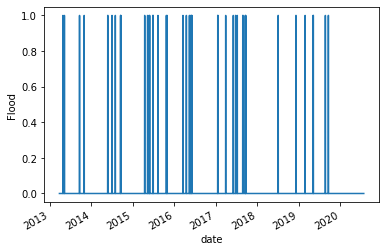

In [89]:
df['flood'].plot()
plt.ylabel('Flood')

In [85]:
df[df['flood'] == 1.0].shape

(82, 4)

In [44]:
# Preliminary model
    # model and plot confusion matrix to optimize for type II errors (i.e no flood when true is flood)

# It is key that we stratify Y here as there are few instances of our target (floods) actually recorded. 
# ALSO SHOULD NOTE THAT THERE WILL BE AUTOCORR WITH ENGINEERED FEATURES AND MULTICOLL WITH TIME
feats = ['water_level', 'water_chg', "water_pct_chg"]

X = df[feats]
y = df['flood']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 42)

lr = LogisticRegression()
lr.fit(X_train, y_train)
n1 = '\n'
print(f"Our preliminary model will predict flood occurrence with {round((lr.score(X_train_df, y_train))*100,1)}% accurracy.{n1}Untrained data will predict with {round((lr.score(X_test_df, y_test))*100,1)}% accurracy.")

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0

In [17]:
# Ensemble Models
knn_pipe = Pipeline([('ss', StandardScaler(with_mean = False)),
                    ('knn', KNeighborsClassifier())])

vote = VotingClassifier([('ada', AdaBoostClassifier()),
                        ('grad_boost', GradientBoostingClassifier()),
                         ('XGB', xgb.XGBClassifier()),
                        ('knn_pipe', knn_pipe)])

# MUST USE DUNDERS TO DENOTE MODELS B/C OF SHARED PARAMS
params = {
    'ada__n_estimators': [100, 150, 200],
    'knn_pipe__knn__n_neighbors' : [1,2,3,4,5,10,20],
    'XGB__max_depth' : [10, 20, 30, 40],
    'XGB__booster' : ['gbtree', 'gblinear', 'dart']
}
# with KNN there are two levels to go through i.e 2 dunders
gs = GridSearchCV(vote, params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

NameError: name 'X_train' is not defined

In [ ]:
knn_pipe = Pipeline([('ss', StandardScaler(with_mean = False)),
                    ('knn', KNeighborsClassifier())])

vote = VotingClassifier([('ada', AdaBoostClassifier()),
                        ('grad_boost', GradientBoostingClassifier()),
                         ('XGB', xgb.XGBClassifier()),
                        ('knn_pipe', knn_pipe)])

# MUST USE DUNDERS TO DENOTE MODELS B/C OF SHARED PARAMS
params = {
    'ada__n_estimators': [100, 150, 200],
    'knn_pipe__knn__n_neighbors' : [1,2,3,4,5,10,20],
    'XGB__max_depth' : [10, 20, 30, 40],
    'XGB__booster' : ['gbtree', 'gblinear', 'dart']
}
# with KNN there are two levels to go through i.e 2 dunders
gs = GridSearchCV(vote, params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

---
#### Model Measurement
---

In [ ]:
preds = gs.predict(X_test)
tn,fp,fn,tp = confusion_matrix(y_test,preds).ravel()
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

# Calc'ing how often it is accurately predicting flooding
tp/(tp+fn)

In [16]:
%%javascript

var num = 8;

console.log(num)

//print(num);

<IPython.core.display.Javascript object>